In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
import numpy as np
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
file_path=r"table-2.csv"
cep=pd.read_csv(file_path)
ra_array = np.array(cep['ra']) * u.degree
dec_array = np.array(cep['dec']) * u.degree
distance_array = (np.array(cep['parallax']) * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = np.array(cep['pmra']) * u.mas / u.yr
pm_dec_array = np.array(cep['pmdec']) * u.mas / u.yr
radial_velocity_array = np.array(cep['radial_velocity']) * u.km / u.s
l=np.array(cep['l']) * au.degree
b=np.array(cep['b']) * u.degree 



In [54]:
max(distance_array)

<Quantity 25.825613 kpc>

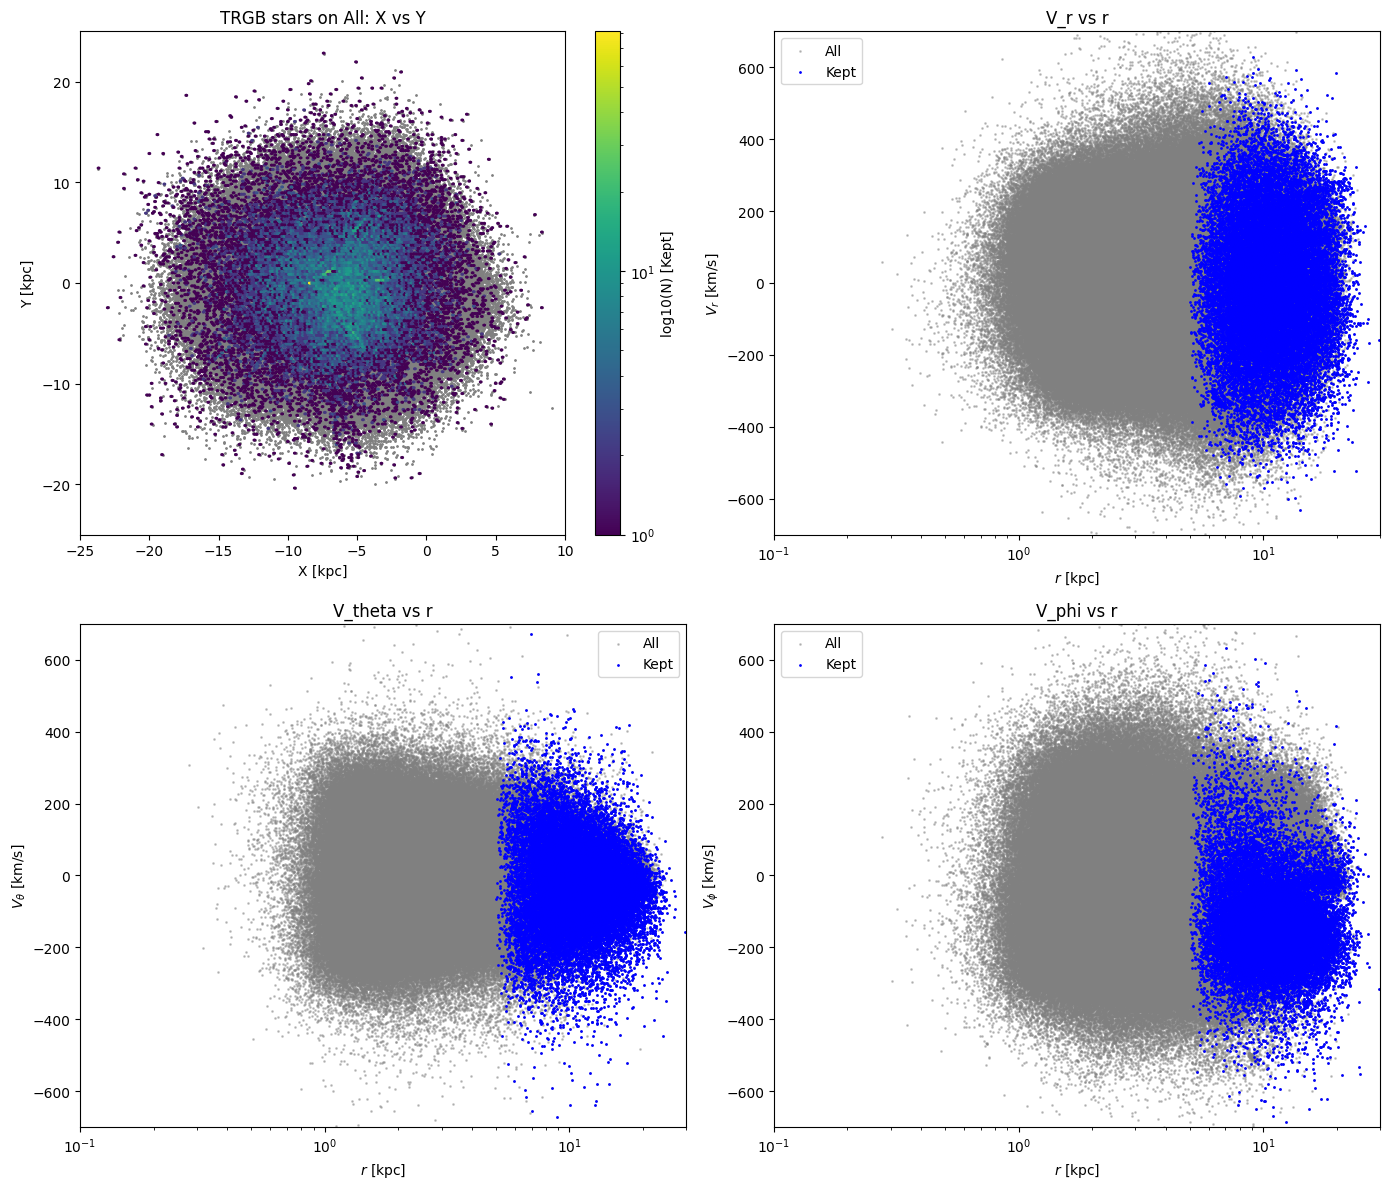

In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV ===
cep = pd.read_csv(r"table-2.csv")
ra_array = np.array(cep['ra']) * u.deg
dec_array = np.array(cep['dec']) * u.deg
distance_array = (np.array(cep['parallax']) * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = np.array(cep['pmra']) * u.mas/u.yr
pm_dec_array = np.array(cep['pmdec']) * u.mas/u.yr
radial_velocity_array = np.array(cep['radial_velocity']) * u.km/u.s
l = np.array(cep['l']) * u.deg
b = np.array(cep['b']) * u.deg

# === Galactic constants ===
U_sun, V_sun, W_sun = 11.1*u.km/u.s, 12.24*u.km/u.s, 7.25*u.km/u.s
V0 = 229 * u.km/u.s
R0 = 8.3 * u.kpc

# === Transform function ===
def transform_to_galactocentric(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity):
    c = SkyCoord(ra=ra, dec=dec, distance=distance,
                 pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec,
                 radial_velocity=radial_velocity)
    g = c.transform_to(Galactocentric(galcen_distance=R0,
                                      z_sun=0.020*u.kpc,
                                      galcen_v_sun=[U_sun, V_sun, W_sun]))
    
    x, y, z = g.x.value, g.y.value, g.z.value
    vx, vy, vz = g.v_x.value, g.v_y.value, g.v_z.value

    X, Y, Z = x, y, z
    U, V, W = vx, vy, vz

    r = np.sqrt(X**2 + Y**2 + Z**2)
    phi = np.arctan2(Y, X)
    theta = np.pi/2 - np.arctan2(Z, np.sqrt(X**2 + Y**2))

    V_r = (U * np.cos(phi) + V * np.sin(phi)) * np.sin(theta) + W * np.cos(theta)
    V_theta = (U * np.cos(phi) + V * np.sin(phi)) * np.cos(theta) - W * np.sin(theta)
    V_phi = U * np.sin(phi) - V * np.cos(phi)

    return {
        "r": r,
        "z": Z,
        "X": X,
        "Y": Y,
        "V_r": V_r,
        "V_theta": V_theta,
        "V_phi": V_phi
    }

# === Transform data ===
results = transform_to_galactocentric(ra_array, dec_array, distance_array,
                                      pm_ra_cosdec_array, pm_dec_array,
                                      radial_velocity_array)

r = results["r"]
z = results["z"]
X = results["X"]
Y = results["Y"]
V_r = results["V_r"]
V_theta = results["V_theta"]
V_phi = results["V_phi"]

# === Plot ===
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
k = 25  # extent for hexbin in kpc

# --- Upper Left: X vs Y ---
axs[0, 0].scatter(X, Y, color='gray', s=1, alpha=1)
hb_kept = axs[0, 0].hexbin(X[np.abs(z) > 5], Y[np.abs(z) > 5], gridsize=300,
                           cmap='viridis', bins='log', extent=(-k, k, -k, k))
axs[0, 0].set_title("TRGB stars on All: X vs Y")
axs[0, 0].set_xlabel("X [kpc]")
axs[0, 0].set_ylabel("Y [kpc]")
axs[0, 0].set_xlim(-25, 10)
axs[0, 0].set_ylim(-k, k)
fig.colorbar(hb_kept, ax=axs[0, 0], label='log10(N) [Kept]')

# --- Upper Right: V_r vs r ---
axs[0, 1].scatter(r, V_r, s=1, color='gray', alpha=0.4, label='All')
axs[0, 1].scatter(r[np.abs(z) > 5], V_r[np.abs(z) > 5], s=1, color='blue', label='Kept')
axs[0, 1].set_title("V_r vs r")
axs[0, 1].set_xlabel(r'$r$ [kpc]')
axs[0, 1].set_ylabel(r'$V_{r}$ [km/s]')
axs[0, 1].set_xlim(0.1, 30)  # Avoid log(0)
axs[0, 1].set_ylim(-700, 700)
axs[0, 1].set_xscale('log')  # <-- log x-axis
axs[0, 1].legend()

# --- Lower Left: V_theta vs r ---
axs[1, 0].scatter(r, V_theta, s=1, color='gray', alpha=0.4, label='All')
axs[1, 0].scatter(r[np.abs(z) > 5], V_theta[np.abs(z) > 5], s=1, color='blue', label='Kept')
axs[1, 0].set_title("V_theta vs r")
axs[1, 0].set_xlabel(r'$r$ [kpc]')
axs[1, 0].set_ylabel(r'$V_{\theta}$ [km/s]')
axs[1, 0].set_xlim(0.1, 30)
axs[1, 0].set_ylim(-700, 700)
axs[1, 0].set_xscale('log')  # <-- log x-axis
axs[1, 0].legend()

# --- Lower Right: V_phi vs r ---
axs[1, 1].scatter(r, V_phi, s=1, color='gray', alpha=0.4, label='All')
axs[1, 1].scatter(r[np.abs(z) > 5], V_phi[np.abs(z) > 5], s=1, color='blue', label='Kept')
axs[1, 1].set_title("V_phi vs r")
axs[1, 1].set_xlabel(r'$r$ [kpc]')
axs[1, 1].set_ylabel(r'$V_{\phi}$ [km/s]')
axs[1, 1].set_xlim(0.1, 30)
axs[1, 1].set_ylim(-700, 700)
axs[1, 1].set_xscale('log')  # <-- log x-axis
axs[1, 1].legend()

plt.tight_layout()
plt.show()



In [5]:
max(r)

28.75451610479729

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15884\3237880991.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1, 0].set_ylim(-700, 700)


<Figure size 640x480 with 0 Axes>

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15884\1457808649.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,100)


(4.578225949162823, 100)

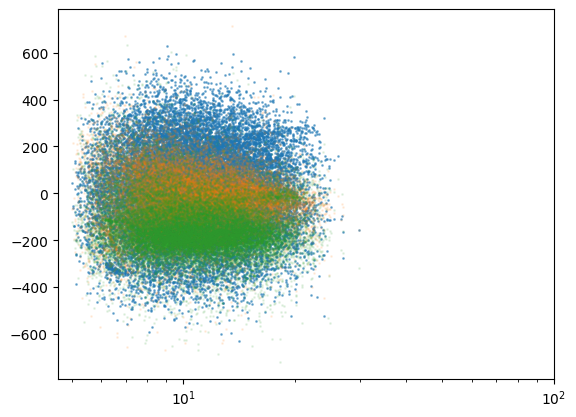

In [7]:
plt.scatter(r[np.abs(z)>5],V_r[np.abs(z)>5],s=1,alpha=0.5)
plt.scatter(r[np.abs(z)>5],V_theta[np.abs(z)>5],s=1,alpha=0.1)
plt.scatter(r[np.abs(z)>5],V_phi[np.abs(z)>5],s=1,alpha=0.1)
plt.xscale('log')
plt.xlim(0,100)

Applying |z| > 5 filter...
Particles after |z| > 5 filter: 34833

Computing dispersions...
Robust + Adaptive binning...
Standard + Logarithmic binning...
Calculating anisotropy parameter β...


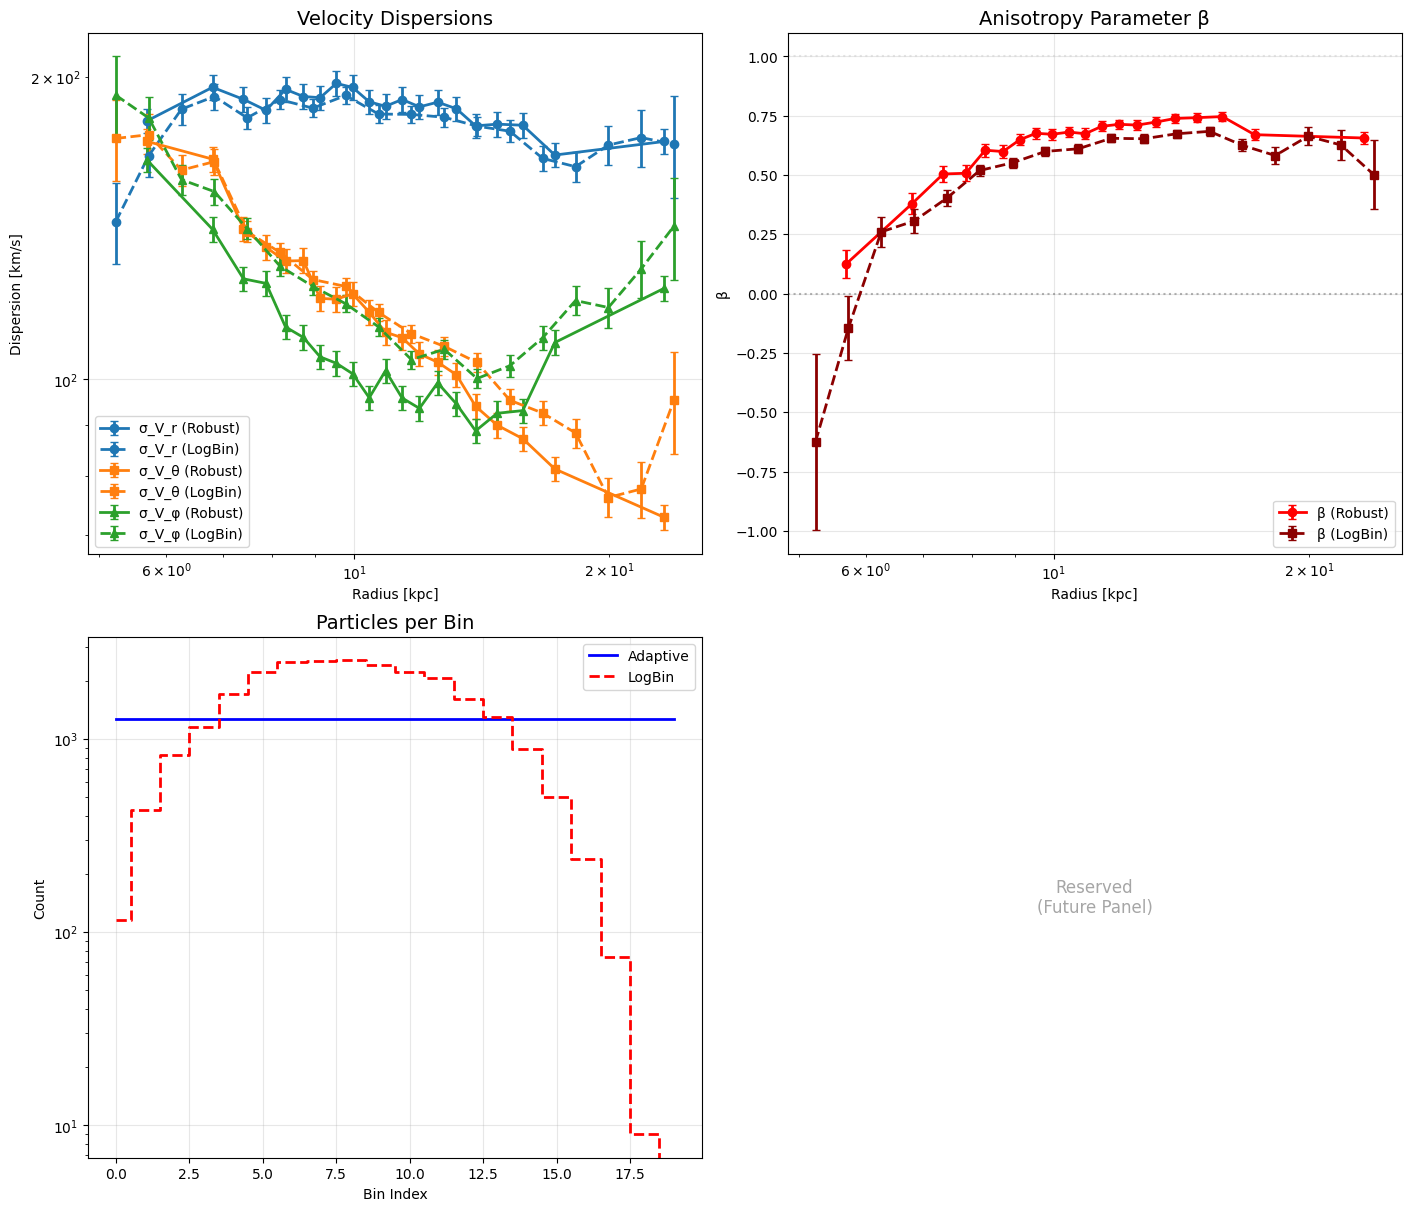


COMPARISON SUMMARY:
Total particles: 34833
Adaptive bins: 20
Logarithmic bins: 20
Valid adaptive bins: V_r:20, V_θ:20, V_φ:20
Valid log bins: V_r:18, V_θ:18, V_φ:18
Valid β bins: Robust:20, Standard:18

Detailed Comparison (First 8 bins):
Method      | Bin# | Radius   | σ_Vr   | σ_Vθ   | σ_Vφ   | β      | β_err  | N_particles
-----------------------------------------------------------------------------------------------
Adaptive    |   0  |    5.69 | 180.77 | 172.55 | 165.44 |   0.13 |   0.06 |     1266
Adaptive    |   1  |    6.81 | 195.30 | 165.64 | 141.00 |   0.38 |   0.04 |     1265
Adaptive    |   2  |    7.40 | 189.97 | 141.21 | 125.88 |   0.50 |   0.03 |     1266
Adaptive    |   3  |    7.87 | 185.25 | 135.31 | 124.57 |   0.51 |   0.03 |     1265
Adaptive    |   4  |    8.30 | 194.38 | 131.11 | 112.72 |   0.60 |   0.03 |     1266
Adaptive    |   5  |    8.71 | 191.21 | 131.26 | 110.05 |   0.60 |   0.03 |     1265
Adaptive    |   6  |    9.11 | 190.70 | 120.36 | 105.25 |   0.65 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
n_bins=20

def robust_sigma(data):
    """
    Optimized robust sigma estimator using biweight midvariance.
    """
    y = np.asarray(data, dtype=float)
    if y.size == 0:
        return np.nan
    
    # Use median as robust center
    y0 = np.median(y)
    
    # Compute MAD (Median Absolute Deviation)
    mad = np.median(np.abs(y - y0)) / 0.6745
    
    # Handle degenerate case
    if mad < 1e-20:
        mad = np.mean(np.abs(y - y0)) / 0.80
    
    # Compute u values (standardized residuals)
    u = (y - y0) / (6.0 * mad)
    
    # Only use points within |u| <= 1 (biweight cutoff)
    mask_u = np.abs(u) <= 1.0
    n_valid = np.sum(mask_u)
    
    if n_valid < 3:
        return np.nan
    
    # Compute biweight midvariance using vectorized operations
    u_valid = u[mask_u]
    y_valid = y[mask_u]
    u2 = u_valid * u_valid
    
    # Biweight variance formula
    weights = (1 - u2) * (1 - u2)  # (1-u²)²
    num = np.sum((y_valid - y0)**2 * weights * weights)  # (1-u²)⁴
    den = np.sum((1 - u2) * (1 - 5.0 * u2))
    
    # Handle degenerate denominator
    if den <= 0:
        return np.nan
    
    # Final biweight midvariance
    sigma2 = len(y) * num / (den * (den - 1))
    
    return np.sqrt(sigma2) if sigma2 > 0 else 0.0

def fast_adaptive_binning(r, n_bins, min_particles=15):
    """
    Fast adaptive binning using quantiles.
    """
    n_total = len(r)
    
    # Calculate target particles per bin
    target_per_bin = max(min_particles, n_total // n_bins)
    
    # Use quantiles for fast binning
    n_bins_actual = min(n_bins, n_total // min_particles)
    
    # Create quantiles
    quantiles = np.linspace(0, 1, n_bins_actual + 1)
    bin_edges = np.quantile(r, quantiles)
    
    # Ensure unique bin edges
    bin_edges = np.unique(bin_edges)
    
    # Calculate bin centers (geometric mean for log-spaced data)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    
    return bin_edges, bin_centers

def compute_fast_binned_dispersion(r, velocities, n_bins, min_particles=15, robust=True):
    """
    Fast computation of binned velocity dispersion.
    """
    # Quick data cleaning
    valid_mask = np.isfinite(r) & np.isfinite(velocities)
    r_clean = r[valid_mask]
    v_clean = velocities[valid_mask]
    
    n_valid = len(r_clean)
    
    if n_valid < min_particles:
        return None, None, None, None, None
    
    # Fast adaptive binning
    bin_edges, bin_centers = fast_adaptive_binning(r_clean, n_bins, min_particles)
    n_bins_actual = len(bin_centers)
    
    # Pre-allocate arrays
    dispersion = np.full(n_bins_actual, np.nan)
    dispersion_error = np.full(n_bins_actual, np.nan)
    bin_counts = np.zeros(n_bins_actual, dtype=int)
    
    # Vectorized binning using digitize
    bin_indices = np.digitize(r_clean, bin_edges) - 1
    
    # Process each bin
    for i in range(n_bins_actual):
        mask = (bin_indices == i)
        v_bin = v_clean[mask]
        N = len(v_bin)
        bin_counts[i] = N
        
        if N >= min_particles:
            if robust:
                # Compute robust dispersion
                disp = robust_sigma(v_bin)
            else:
                # Compute standard dispersion
                disp = np.std(v_bin, ddof=1)
            
            if np.isfinite(disp):
                dispersion[i] = disp
                # Simple error estimate
                dispersion_error[i] = disp / np.sqrt(N)
    
    valid_bins = np.isfinite(dispersion)
    
    return bin_centers, dispersion, dispersion_error, bin_counts, valid_bins

def compute_standard_log_binned_dispersion(r, velocities, n_bins, min_particles=15, robust=True):
    """
    Standard logarithmic binning for comparison.
    """
    # Quick data cleaning
    valid_mask = np.isfinite(r) & np.isfinite(velocities)
    r_clean = r[valid_mask]
    v_clean = velocities[valid_mask]
    
    n_valid = len(r_clean)
    
    if n_valid < min_particles:
        return None, None, None, None, None
    
    # Standard logarithmic binning
    r_min, r_max = np.min(r_clean), np.max(r_clean)
    bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    
    # Pre-allocate arrays
    dispersion = np.full(n_bins, np.nan)
    dispersion_error = np.full(n_bins, np.nan)
    bin_counts = np.zeros(n_bins, dtype=int)
    
    # Process each bin
    for i in range(n_bins):
        mask = (r_clean >= bin_edges[i]) & (r_clean < bin_edges[i+1])
        v_bin = v_clean[mask]
        N = len(v_bin)
        bin_counts[i] = N
        
        if N >= min_particles:
            if robust:
                # Compute robust dispersion
                disp = robust_sigma(v_bin)
            else:
                # Compute standard dispersion
                disp = np.std(v_bin, ddof=1)
            
            if np.isfinite(disp):
                dispersion[i] = disp
                # Simple error estimate
                dispersion_error[i] = disp / np.sqrt(N)
    
    valid_bins = np.isfinite(dispersion)
    
    return bin_centers, dispersion, dispersion_error, bin_counts, valid_bins

def calculate_anisotropy_beta(sigma_r, sigma_theta, sigma_phi, 
                             sigma_r_err, sigma_theta_err, sigma_phi_err):
    """
    Calculate anisotropy parameter β = 1 - (σ_θ² + σ_φ²)/(2σ_r²)
    with proper error propagation.
    
    Parameters:
    -----------
    sigma_r, sigma_theta, sigma_phi : array-like
        Velocity dispersions in radial, theta, and phi directions
    sigma_r_err, sigma_theta_err, sigma_phi_err : array-like
        Errors in velocity dispersions
    
    Returns:
    --------
    beta : array
        Anisotropy parameter
    beta_err : array
        Error in anisotropy parameter
    """
    # Convert to numpy arrays
    sigma_r = np.asarray(sigma_r)
    sigma_theta = np.asarray(sigma_theta)
    sigma_phi = np.asarray(sigma_phi)
    sigma_r_err = np.asarray(sigma_r_err)
    sigma_theta_err = np.asarray(sigma_theta_err)
    sigma_phi_err = np.asarray(sigma_phi_err)
    
    # Calculate beta
    sigma_r_sq = sigma_r**2
    sigma_theta_sq = sigma_theta**2
    sigma_phi_sq = sigma_phi**2
    
    # β = 1 - (σ_θ² + σ_φ²)/(2σ_r²)
    tangential_sum = sigma_theta_sq + sigma_phi_sq
    beta = 1 - tangential_sum / (2 * sigma_r_sq)
    
    # Error propagation using partial derivatives
    # ∂β/∂σ_r = (σ_θ² + σ_φ²) / σ_r³
    # ∂β/∂σ_θ = -σ_θ / σ_r²
    # ∂β/∂σ_φ = -σ_φ / σ_r²
    
    dBeta_dSigmaR = tangential_sum / (sigma_r**3)
    dBeta_dSigmaTheta = -sigma_theta / sigma_r_sq
    dBeta_dSigmaPhi = -sigma_phi / sigma_r_sq
    
    # Error propagation: σ_β² = (∂β/∂σ_r)²σ_r² + (∂β/∂σ_θ)²σ_θ² + (∂β/∂σ_φ)²σ_φ²
    beta_err_sq = (dBeta_dSigmaR * sigma_r_err)**2 + \
                  (dBeta_dSigmaTheta * sigma_theta_err)**2 + \
                  (dBeta_dSigmaPhi * sigma_phi_err)**2
    
    beta_err = np.sqrt(beta_err_sq)
    
    # Handle invalid values
    valid_mask = np.isfinite(sigma_r) & np.isfinite(sigma_theta) & np.isfinite(sigma_phi) & \
                 (sigma_r > 0) & (sigma_theta >= 0) & (sigma_phi >= 0)
    
    beta = np.where(valid_mask, beta, np.nan)
    beta_err = np.where(valid_mask, beta_err, np.nan)
    
    return beta, beta_err

# Apply the condition |z| > 5
print("Applying |z| > 5 filter...")
condition = np.abs(z) > 5
r_filtered = r[condition]
V_r_filtered = V_r[condition]
V_theta_filtered = V_theta[condition]
V_phi_filtered = V_phi[condition]

print(f"Particles after |z| > 5 filter: {len(r_filtered)}")

# Compute dispersions with different methods
print("\nComputing dispersions...")

# Robust + Adaptive binning (solid lines)
print("Robust + Adaptive binning...")
robust_adaptive_r = compute_fast_binned_dispersion(r_filtered, V_r_filtered, n_bins, robust=True)
robust_adaptive_theta = compute_fast_binned_dispersion(r_filtered, V_theta_filtered, n_bins, robust=True)
robust_adaptive_phi = compute_fast_binned_dispersion(r_filtered, V_phi_filtered, n_bins, robust=True)

# Standard + Logarithmic binning (dashed lines)
print("Standard + Logarithmic binning...")
standard_log_r = compute_standard_log_binned_dispersion(r_filtered, V_r_filtered, n_bins, robust=False)
standard_log_theta = compute_standard_log_binned_dispersion(r_filtered, V_theta_filtered, n_bins, robust=False)
standard_log_phi = compute_standard_log_binned_dispersion(r_filtered, V_phi_filtered, n_bins, robust=False)

# Calculate anisotropy beta for both methods
print("Calculating anisotropy parameter β...")

# For robust + adaptive method
if robust_adaptive_r[0] is not None:
    beta_robust, beta_robust_err = calculate_anisotropy_beta(
        robust_adaptive_r[1], robust_adaptive_theta[1], robust_adaptive_phi[1],
        robust_adaptive_r[2], robust_adaptive_theta[2], robust_adaptive_phi[2]
    )
    
# For standard + logarithmic method
if standard_log_r[0] is not None:
    beta_standard, beta_standard_err = calculate_anisotropy_beta(
        standard_log_r[1], standard_log_theta[1], standard_log_phi[1],
        standard_log_r[2], standard_log_theta[2], standard_log_phi[2]
    )

# Check if we have valid results
if robust_adaptive_r[0] is not None and standard_log_r[0] is not None:
    
    # Create comprehensive comparison plot with anisotropy

    
    # Colors for each velocity component
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    # ROBUST + ADAPTIVE (SOLID LINES)
    robust_results = [robust_adaptive_r, robust_adaptive_theta, robust_adaptive_phi]
    component_names = ['V_r', 'V_θ', 'V_φ']
    markers = ['o', 's', '^']
    
    for i, (results, name, color, marker) in enumerate(zip(robust_results, component_names, colors, markers)):
        bin_centers, dispersion, disp_error, bin_counts, valid_bins = results
        if np.any(valid_bins):
            ax1.errorbar(bin_centers[valid_bins], dispersion[valid_bins], 
                        yerr=disp_error[valid_bins], 
                        fmt=marker+'-', color=color, linewidth=2.5, markersize=8,
                        capsize=4, alpha=0.9, 
                        label=f'σ_{{{name}}} (Robust+Adaptive)')
    
    # STANDARD + LOGARITHMIC (DASHED LINES)
    standard_results = [standard_log_r, standard_log_theta, standard_log_phi]
    
    for i, (results, name, color, marker) in enumerate(zip(standard_results, component_names, colors, markers)):
        bin_centers, dispersion, disp_error, bin_counts, valid_bins = results
        if np.any(valid_bins):
            ax1.errorbar(bin_centers[valid_bins], dispersion[valid_bins], 
                        yerr=disp_error[valid_bins], 
                        fmt=marker+'--', color=color, linewidth=2.5, markersize=8,
                        capsize=4, alpha=0.7, 
                        label=f'σ_{{{name}}} (Standard+LogBin)')
    
import matplotlib.pyplot as plt

if robust_adaptive_r[0] is not None and standard_log_r[0] is not None:

    fig, axs = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)

    # -------------------------------------
    # Panel 1: Velocity Dispersions
    # -------------------------------------
    ax = axs[0, 0]
    ax.set_title("Velocity Dispersions", fontsize=14)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    labels = ['V_r', 'V_θ', 'V_φ']
    markers = ['o', 's', '^']

    for i, (robust, standard, label, color, marker) in enumerate(zip(
        [robust_adaptive_r, robust_adaptive_theta, robust_adaptive_phi],
        [standard_log_r, standard_log_theta, standard_log_phi],
        labels, colors, markers
    )):
        # Robust
        if np.any(robust[4]):
            ax.errorbar(robust[0][robust[4]], robust[1][robust[4]],
                        yerr=robust[2][robust[4]],
                        fmt=marker+'-', color=color, label=f'σ_{label} (Robust)',
                        lw=2, capsize=3, markersize=6)
        # Standard
        if np.any(standard[4]):
            ax.errorbar(standard[0][standard[4]], standard[1][standard[4]],
                        yerr=standard[2][standard[4]],
                        fmt=marker+'--', color=color, label=f'σ_{label} (LogBin)',
                        lw=2, capsize=3, markersize=6)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Radius [kpc]")
    ax.set_ylabel("Dispersion [km/s]")
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    # -------------------------------------
    # Panel 2: Anisotropy β
    # -------------------------------------
    ax = axs[0, 1]
    ax.set_title("Anisotropy Parameter β", fontsize=14)

    if np.any(valid_beta_robust):
        ax.errorbar(robust_adaptive_r[0][valid_beta_robust], beta_robust[valid_beta_robust],
                    yerr=beta_robust_err[valid_beta_robust],
                    fmt='o-', color='red', label='β (Robust)',
                    lw=2, capsize=3, markersize=6)

    if np.any(valid_beta_standard):
        ax.errorbar(standard_log_r[0][valid_beta_standard], beta_standard[valid_beta_standard],
                    yerr=beta_standard_err[valid_beta_standard],
                    fmt='s--', color='darkred', label='β (LogBin)',
                    lw=2, capsize=3, markersize=6)

    ax.axhline(0, ls=':', color='gray', alpha=0.6)
    ax.axhline(1, ls=':', color='lightgray', alpha=0.6)

    ax.set_xscale('log')
    ax.set_xlabel("Radius [kpc]")
    ax.set_ylabel("β")
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    # -------------------------------------
    # Panel 3: Bin Particle Counts
    # -------------------------------------
    ax = axs[1, 0]
    ax.set_title("Particles per Bin", fontsize=14)
    ax.step(np.arange(len(robust_adaptive_r[3])), robust_adaptive_r[3], where='mid',
            label='Adaptive', color='blue', lw=2)
    ax.step(np.arange(len(standard_log_r[3])), standard_log_r[3], where='mid',
            label='LogBin', color='red', lw=2, linestyle='--')
    ax.set_yscale('log')
    ax.set_xlabel("Bin Index")
    ax.set_ylabel("Count")
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    # -------------------------------------
    # Panel 4: (Leave Blank)
    # -------------------------------------
    axs[1, 1].axis('off')
    axs[1, 1].text(0.5, 0.5, "Reserved\n(Future Panel)", fontsize=12,
                   ha='center', va='center', color='gray', alpha=0.7)

    plt.show()

    
    # =================== SUMMARY STATISTICS ===================
    print(f"\n" + "="*80)
    print("COMPARISON SUMMARY:")
    print(f"Total particles: {len(r_filtered)}")
    print(f"Adaptive bins: {len(bin_centers_adapt)}")
    print(f"Logarithmic bins: {len(bin_centers_log)}")
    print(f"Valid adaptive bins: V_r:{np.sum(robust_adaptive_r[4])}, V_θ:{np.sum(robust_adaptive_theta[4])}, V_φ:{np.sum(robust_adaptive_phi[4])}")
    print(f"Valid log bins: V_r:{np.sum(standard_log_r[4])}, V_θ:{np.sum(standard_log_theta[4])}, V_φ:{np.sum(standard_log_phi[4])}")
    print(f"Valid β bins: Robust:{np.sum(valid_beta_robust)}, Standard:{np.sum(valid_beta_standard)}")
    
    # Detailed comparison table with anisotropy
    print(f"\nDetailed Comparison (First 8 bins):")
    print("Method      | Bin# | Radius   | σ_Vr   | σ_Vθ   | σ_Vφ   | β      | β_err  | N_particles")
    print("-" * 95)
    
    for i in range(min(8, len(bin_centers_adapt))):
        if counts_adapt[i] > 0:
            r_adapt = robust_adaptive_r[1][i] if robust_adaptive_r[4][i] else np.nan
            t_adapt = robust_adaptive_theta[1][i] if robust_adaptive_theta[4][i] else np.nan
            p_adapt = robust_adaptive_phi[1][i] if robust_adaptive_phi[4][i] else np.nan
            beta_val = beta_robust[i] if valid_beta_robust[i] else np.nan
            beta_err_val = beta_robust_err[i] if valid_beta_robust[i] else np.nan
            
            print(f"Adaptive    | {i:3d}  | {bin_centers_adapt[i]:7.2f} | {r_adapt:6.2f} | {t_adapt:6.2f} | {p_adapt:6.2f} | {beta_val:6.2f} | {beta_err_val:6.2f} | {counts_adapt[i]:8d}")
    
    print("-" * 95)
    for i in range(min(8, len(bin_centers_log))):
        if counts_log[i] > 0:
            r_log = standard_log_r[1][i] if standard_log_r[4][i] else np.nan
            t_log = standard_log_theta[1][i] if standard_log_theta[4][i] else np.nan
            p_log = standard_log_phi[1][i] if standard_log_phi[4][i] else np.nan
            beta_val = beta_standard[i] if valid_beta_standard[i] else np.nan
            beta_err_val = beta_standard_err[i] if valid_beta_standard[i] else np.nan
            
            print(f"Logarithmic | {i:3d}  | {bin_centers_log[i]:7.2f} | {r_log:6.2f} | {t_log:6.2f} | {p_log:6.2f} | {beta_val:6.2f} | {beta_err_val:6.2f} | {counts_log[i]:8d}")
    
    # =================== ANISOTROPY INTERPRETATION ===================
    print(f"\n" + "="*80)
    print("ANISOTROPY INTERPRETATION:")
    print("β > 0  : Radially anisotropic (radial motions dominate)")
    print("β = 0  : Isotropic (equal dispersions in all directions)")
    print("β < 0  : Tangentially anisotropic (tangential motions dominate)")
    print("β = 1  : Purely radial orbits")
    print("β = -∞ : Purely tangential/circular orbits")
    
    # Statistical summary of beta values
    if np.any(valid_beta_robust):
        beta_mean_robust = np.nanmean(beta_robust[valid_beta_robust])
        beta_std_robust = np.nanstd(beta_robust[valid_beta_robust])
        print(f"\nRobust+Adaptive β: mean = {beta_mean_robust:.3f} ± {beta_std_robust:.3f}")
    
    if np.any(valid_beta_standard):
        beta_mean_standard = np.nanmean(beta_standard[valid_beta_standard])
        beta_std_standard = np.nanstd(beta_standard[valid_beta_standard])
        print(f"Standard+LogBin β: mean = {beta_mean_standard:.3f} ± {beta_std_standard:.3f}")

else:
    print("Error: Insufficient data for dispersion calculation!")

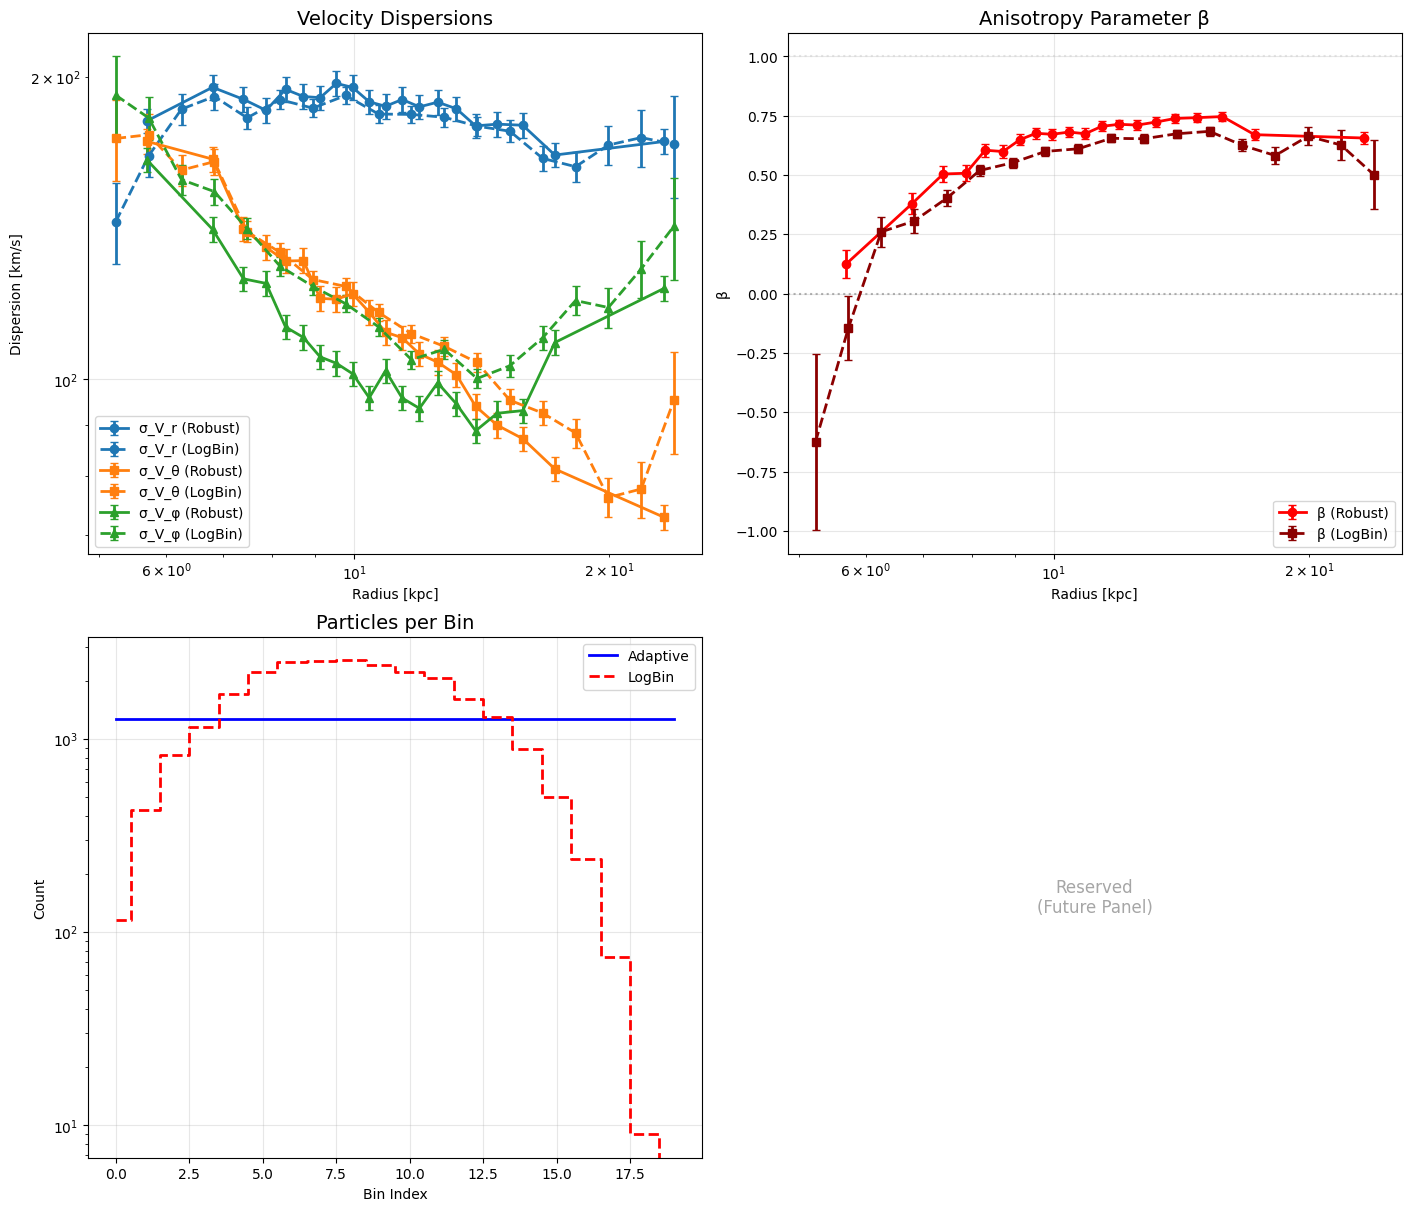

c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


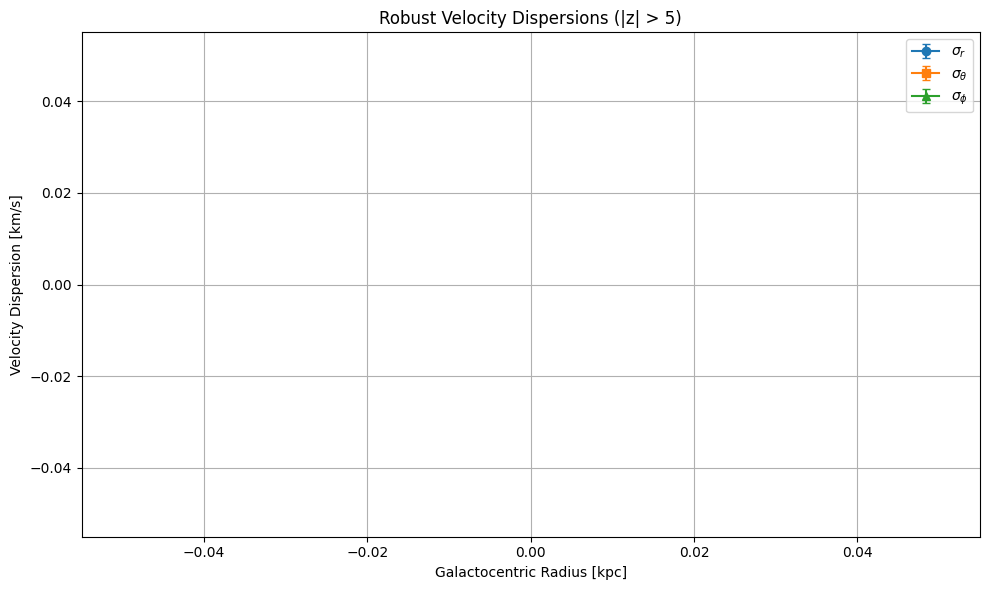

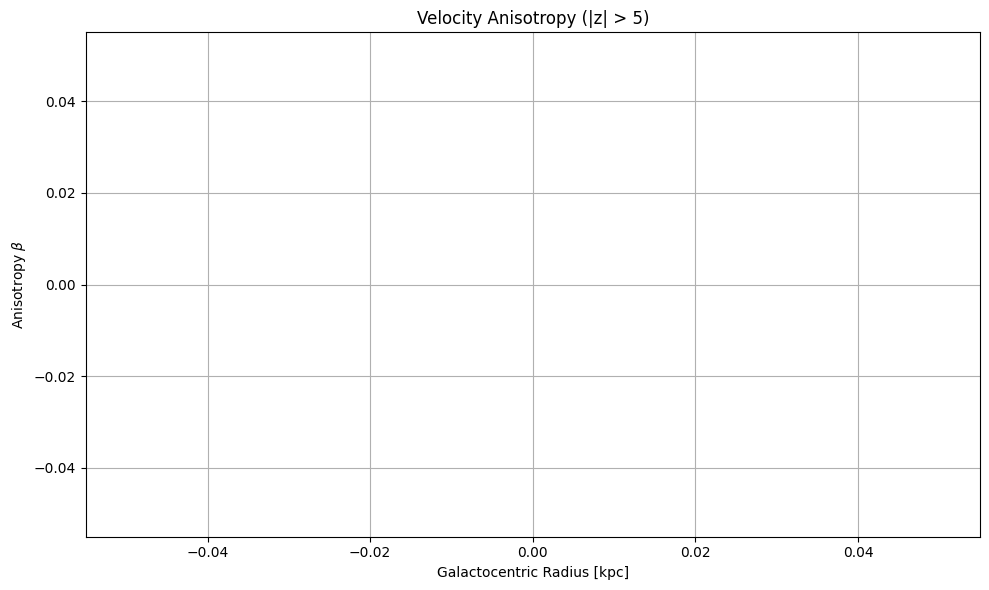

In [46]:
# 6. Robust dispersion estimator
# ----------------------------------------
def robust_sigma(data):
    y = np.array(data, dtype=float).ravel()
    if y.size == 0:
        return np.nan
    y0 = np.median(y)
    mad = np.median(np.abs(y - y0)) / 0.6745
    if mad < 1e-20:
        mad = np.mean(np.abs(y - y0)) / 0.80
    u = (y - y0) / (6.0 * mad)
    mask_u = np.abs(u) <= 1.0
    if mask_u.sum() < 3:
        return np.nan
    u2 = u[mask_u]**2
    y_core = y[mask_u]
    num = np.sum((y_core - y0)**2 * (1 - u2)**4)
    den = np.sum((1 - u2) * (1 - 5.0 * u2))
    sigma2 = len(y) * num / (den * (den - 1))
    return np.sqrt(sigma2) if sigma2 > 0 else 0.0

# ----------------------------------------
# 7. Bin and compute statistics
# -----------------------------------A-----


bin_edges = np.linspace(0,30 , 10)
   
            # np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
            # np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
            # np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:],
            # np.linspace(1000, 1200, 2)[1:]
        
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

def compute_binned_stats(r, v):
    stats = []
    for i in range(len(bin_centers)):
        mask = (r >= bin_edges[i]) & (r < bin_edges[i+1])
        if np.sum(mask) >= 0:
            v_bin = v[mask]
            sig = robust_sigma(v_bin)
            err = sig / np.sqrt(2 * (np.sum(mask) - 1))
            med = np.median(v_bin)
        else:
            sig = err = med = np.nan
        stats.append((med, sig, err))
    return np.array(stats).T

medVr, sigVr, errVr = compute_binned_stats(r[np.abs(z)>5],V_r[np.abs(z)>5])
medVt, sigVt, errVt = compute_binned_stats(r[np.abs(z)>5],V_theta[np.abs(z)>5])
medVp, sigVp, errVp = compute_binned_stats(r[np.abs(z)>5],V_phi[np.abs(z)>5])

# Anisotropy
beta = 1 - (sigVt**2 + sigVp**2) / (2 * sigVr**2)
d_beta_dsr = (sigVt**2 + sigVp**2) / (sigVr**3)
d_beta_dst = -sigVt / (sigVr**2)
d_beta_dsp = -sigVp / (sigVr**2)
beta_err = np.sqrt((d_beta_dsr * errVr)**2 +
                   (d_beta_dst * errVt)**2 +
                   (d_beta_dsp * errVp)**2)

# Plot robust velocity dispersions
# ----------------------------------------

plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, sigVr, yerr=errVr, fmt='o-', label=r'$\sigma_r$', capsize=3)
plt.errorbar(bin_centers, sigVt, yerr=errVt, fmt='s-', label=r'$\sigma_\theta$', capsize=3)
plt.errorbar(bin_centers, sigVp, yerr=errVp, fmt='^-', label=r'$\sigma_\phi$', capsize=3)
plt.xlabel('Galactocentric Radius [kpc]')
plt.ylabel('Velocity Dispersion [km/s]')
plt.title('Robust Velocity Dispersions vs Radius (|z| > 5)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()